In [3]:
## setup_mnist.py -- mnist data and model loading code
##
## Copyright (C) 2016, Nicholas Carlini <nicholas@carlini.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.

import tensorflow as tf
import numpy as np
import os
import pickle
import gzip
import urllib.request

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import load_model

def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(num_images*28*28)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = (data / 255) - 0.5
        data = data.reshape(num_images, 28, 28, 1)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8)
    return (np.arange(10) == labels[:, None]).astype(np.float32)

class MNIST:
    def __init__(self):
        if not os.path.exists("data"):
            os.mkdir("data")
            files = ["train-images-idx3-ubyte.gz",
                     "t10k-images-idx3-ubyte.gz",
                     "train-labels-idx1-ubyte.gz",
                     "t10k-labels-idx1-ubyte.gz"]
            for name in files:

                urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/' + name, "data/"+name)

        train_data = extract_data("data/train-images-idx3-ubyte.gz", 60000)
        train_labels = extract_labels("data/train-labels-idx1-ubyte.gz", 60000)
        self.test_data = extract_data("data/t10k-images-idx3-ubyte.gz", 10000)
        self.test_labels = extract_labels("data/t10k-labels-idx1-ubyte.gz", 10000)
        
        VALIDATION_SIZE = 5000
        
        self.validation_data = train_data[:VALIDATION_SIZE, :, :, :]
        self.validation_labels = train_labels[:VALIDATION_SIZE]
        self.train_data = train_data[VALIDATION_SIZE:, :, :, :]
        self.train_labels = train_labels[VALIDATION_SIZE:]


class MNISTModel:
    def __init__(self, restore, session=None):
        self.num_channels = 1
        self.image_size = 28
        self.num_labels = 10

        model = Sequential()

        model.add(Conv2D(32, (3, 3),
                         input_shape=(28, 28, 1)))
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        
        model.add(Flatten())
        model.add(Dense(200))
        model.add(Activation('relu'))
        model.add(Dense(200))
        model.add(Activation('relu'))
        model.add(Dense(10))
        model.load_weights(restore)

        self.model = model

    def predict(self, data):
        return self.model(data)


In [5]:
## train_models.py -- train the neural network models for attacking
##
## Copyright (C) 2016, Nicholas Carlini <nicholas@carlini.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.


import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

import tensorflow as tf
#from setup_mnist import MNIST
#from setup_cifar import CIFAR
import os

def train(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1, init=None):
    """
    Standard neural network training procedure.
    """
    model = Sequential()

    print(data.train_data.shape)
    
    model.add(Conv2D(params[0], (3, 3),
                            input_shape=data.train_data.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(params[1], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(params[2], (3, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(params[3], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(params[4]))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(params[5]))
    model.add(Activation('relu'))
    model.add(Dense(10))
    
    if init != None:
        model.load_weights(init)

    def fn(correct, predicted):
        return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                       logits=predicted/train_temp)

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    
    model.compile(loss=fn,
                  optimizer=sgd,
                  metrics=['accuracy'])
    
    model.fit(data.train_data, data.train_labels,
              batch_size=batch_size,
              validation_data=(data.validation_data, data.validation_labels),
              nb_epoch=num_epochs,
              shuffle=True)
    

    if file_name != None:
        model.save(file_name)

    return model

def train_distillation(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1):
    """
    Train a network using defensive distillation.

    Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks
    Nicolas Papernot, Patrick McDaniel, Xi Wu, Somesh Jha, Ananthram Swami
    IEEE S&P, 2016.
    """
    if not os.path.exists(file_name+"_init"):
        # Train for one epoch to get a good starting point.
        train(data, file_name+"_init", params, 1, batch_size)
    
    # now train the teacher at the given temperature
    teacher = train(data, file_name+"_teacher", params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # evaluate the labels at temperature t
    predicted = teacher.predict(data.train_data)
    with tf.Session() as sess:
        y = sess.run(tf.nn.softmax(predicted/train_temp))
        print(y)
        data.train_labels = y

    # train the student model at temperature t
    student = train(data, file_name, params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # and finally we predict at temperature 1
    predicted = student.predict(data.train_data)

    print(predicted)
    
if not os.path.isdir('models'):
    os.makedirs('models')

#train(CIFAR(), "models/cifar", [64, 64, 128, 128, 256, 256], num_epochs=50)
train(MNIST(), "models/mnist", [32, 32, 64, 64, 200, 200], num_epochs=50)

#train_distillation(MNIST(), "models/mnist-distilled-100", [32, 32, 64, 64, 200, 200], num_epochs=50, train_temp=100)
#train_distillation(CIFAR(), "models/cifar-distilled-100", [64, 64, 128, 128, 256, 256],num_epochs=50, train_temp=100)


(55000, 28, 28, 1)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
keep_dims is deprecated, use keepdims instead


/Users/raj/anaconda2/envs/dl/lib/python3.5/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 147s 3ms/step - loss: 0.6802 - acc: 0.7719 - val_loss: 0.0854 - val_acc: 0.9742
Epoch 2/50
55000/55000 [==============================] - 144s 3ms/step - loss: 0.1172 - acc: 0.9639 - val_loss: 0.0576 - val_acc: 0.9822
Epoch 3/50
55000/55000 [==============================] - 146s 3ms/step - loss: 0.0850 - acc: 0.9735 - val_loss: 0.0563 - val_acc: 0.9844
Epoch 4/50
55000/55000 [==============================] - 144s 3ms/step - loss: 0.0673 - acc: 0.9788 - val_loss: 0.0472 - val_acc: 0.9880
Epoch 5/50
55000/55000 [==============================] - 145s 3ms/step - loss: 0.0580 - acc: 0.9816 - val_loss: 0.0404 - val_acc: 0.9898
Epoch 6/50
55000/55000 [==============================] - 144s 3ms/step - loss: 0.0498 - acc: 0.9851 - val_loss: 0.0384 - val_acc: 0.9902
Epoch 7/50
55000/55000 [==============================] - 145s 3ms/step - loss: 0.0429 - acc: 0.9865 - val_loss: 0.0369 - v

In [7]:
## verify.py -- check the accuracy of a neural network
##
## Copyright (C) 2016, Nicholas Carlini <nicholas@carlini.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.

#from setup_cifar import CIFAR, CIFARModel
#from setup_mnist import MNIST, MNISTModel
#from setup_inception import ImageNet, InceptionModel

import tensorflow as tf
import numpy as np

BATCH_SIZE = 1

with tf.Session() as sess:
    data, model = MNIST(), MNISTModel("models/mnist", sess)
    #data, model = CIFAR(), CIFARModel("models/cifar", sess)
    #data, model = ImageNet(), InceptionModel(sess)

    x = tf.placeholder(tf.float32, (None, model.image_size, model.image_size, model.num_channels))
    y = model.predict(x)

    r = []
    for i in range(0,len(data.test_data),BATCH_SIZE):
        pred = sess.run(y, {x: data.test_data[i:i+BATCH_SIZE]})
        #print(pred)
        #print('real',data.test_labels[i],'pred',np.argmax(pred))
        r.append(np.argmax(pred,1) == np.argmax(data.test_labels[i:i+BATCH_SIZE],1))
        print('mean: ',np.mean(r))


mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0
mean:  1.0

mean:  0.9953810623556582
mean:  0.9953917050691244
mean:  0.9954022988505747
mean:  0.9954128440366973
mean:  0.9954233409610984
mean:  0.9954337899543378
mean:  0.9954441913439636
mean:  0.9954545454545455
mean:  0.9954648526077098
mean:  0.995475113122172
mean:  0.9954853273137697
mean:  0.9954954954954955
mean:  0.9955056179775281
mean:  0.9932735426008968
mean:  0.9932885906040269
mean:  0.9933035714285714
mean:  0.9933184855233853
mean:  0.9911111111111112
mean:  0.991130820399113
mean:  0.9911504424778761
mean:  0.9911699779249448
mean:  0.9911894273127754
mean:  0.9912087912087912
mean:  0.9912280701754386
mean:  0.9912472647702407
mean:  0.9912663755458515
mean:  0.9912854030501089
mean:  0.991304347826087
mean:  0.9913232104121475
mean:  0.9913419913419913
mean:  0.9913606911447084
mean:  0.9913793103448276
mean:  0.9913978494623656
mean:  0.9914163090128756
mean:  0.9914346895074947
mean:  0.9914529914529915
mean:  0.9914712153518124
mean:  0.9914893617021276
mean:  0.991507

mean:  0.9908376963350786
mean:  0.9908496732026144
mean:  0.9908616187989556
mean:  0.9908735332464146
mean:  0.9908854166666666
mean:  0.9908972691807543
mean:  0.990909090909091
mean:  0.9909208819714657
mean:  0.9909326424870466
mean:  0.9909443725743855
mean:  0.9909560723514211
mean:  0.9909677419354839
mean:  0.990979381443299
mean:  0.990990990990991
mean:  0.9910025706940874
mean:  0.9910141206675225
mean:  0.9910256410256411
mean:  0.9910371318822023
mean:  0.9910485933503836
mean:  0.9910600255427842
mean:  0.9910714285714286
mean:  0.9910828025477707
mean:  0.9910941475826972
mean:  0.9911054637865311
mean:  0.9911167512690355
mean:  0.991128010139417
mean:  0.9911392405063291
mean:  0.9911504424778761
mean:  0.9911616161616161
mean:  0.9911727616645649
mean:  0.9911838790931989
mean:  0.9911949685534591
mean:  0.9912060301507538
mean:  0.9912170639899623
mean:  0.9912280701754386
mean:  0.9912390488110138
mean:  0.99125
mean:  0.9912609238451935
mean:  0.9912718204488778
m

mean:  0.9928057553956835
mean:  0.9919137466307277
mean:  0.9919210053859964
mean:  0.9919282511210762
mean:  0.9919354838709677
mean:  0.9919427036705462
mean:  0.9919499105545617
mean:  0.9919571045576407
mean:  0.9919642857142857
mean:  0.991971454058876
mean:  0.9919786096256684
mean:  0.9919857524487978
mean:  0.9919928825622776
mean:  0.992
mean:  0.9920071047957372
mean:  0.9920141969831411
mean:  0.9920212765957447
mean:  0.9920283436669619
mean:  0.9920353982300885
mean:  0.9920424403183024
mean:  0.9920494699646644
mean:  0.9920564872021183
mean:  0.9920634920634921
mean:  0.9920704845814978
mean:  0.9920774647887324
mean:  0.9920844327176781
mean:  0.992091388400703
mean:  0.9920983318700615
mean:  0.9921052631578947
mean:  0.9921121822962313
mean:  0.9921190893169878
mean:  0.9921259842519685
mean:  0.9921328671328671
mean:  0.9921397379912664
mean:  0.9921465968586387
mean:  0.992153443766347
mean:  0.9921602787456446
mean:  0.9921671018276762
mean:  0.9921739130434782
me

mean:  0.9895470383275261
mean:  0.9895543175487466
mean:  0.9895615866388309
mean:  0.9895688456189151
mean:  0.9895760945100764
mean:  0.9895833333333334
mean:  0.9895905621096461
mean:  0.9895977808599168
mean:  0.9896049896049897
mean:  0.989612188365651
mean:  0.9896193771626297
mean:  0.9896265560165975
mean:  0.9896337249481686
mean:  0.9896408839779005
mean:  0.989648033126294
mean:  0.9896551724137931
mean:  0.9896623018607856
mean:  0.9896694214876033
mean:  0.9896765313145217
mean:  0.9896836313617606
mean:  0.9896907216494846
mean:  0.9896978021978022
mean:  0.9897048730267674
mean:  0.9897119341563786
mean:  0.9897189856065799
mean:  0.9897260273972602
mean:  0.9897330595482546
mean:  0.9897400820793434
mean:  0.9897470950102529
mean:  0.9897540983606558
mean:  0.9897610921501706
mean:  0.9897680763983628
mean:  0.9897750511247444
mean:  0.9897820163487738
mean:  0.989788972089857
mean:  0.9897959183673469
mean:  0.9898028552005439
mean:  0.9898097826086957
mean:  0.989816

mean:  0.9909859154929578
mean:  0.990990990990991
mean:  0.9909960607765897
mean:  0.9910011248593926
mean:  0.9910061832490163
mean:  0.9910112359550561
mean:  0.9910162829870859
mean:  0.9910213243546577
mean:  0.9904655075715086
mean:  0.9904708520179372
mean:  0.9904761904761905
mean:  0.990481522956327
mean:  0.9904868494683827
mean:  0.9904921700223713
mean:  0.9904974846282839
mean:  0.9905027932960894
mean:  0.9905080960357342
mean:  0.9905133928571429
mean:  0.9905186837702176
mean:  0.9905239687848384
mean:  0.9905292479108635
mean:  0.9905345211581291
mean:  0.9905397885364496
mean:  0.9905450500556173
mean:  0.990550305725403
mean:  0.9905555555555555
mean:  0.9905607995558023
mean:  0.9905660377358491
mean:  0.9905712701053799
mean:  0.9905764966740577
mean:  0.9905817174515236
mean:  0.9905869324473976
mean:  0.9905921416712784
mean:  0.9905973451327433
mean:  0.9906025428413489
mean:  0.9906077348066298
mean:  0.9906129210381005
mean:  0.9906181015452539
mean:  0.990623

mean:  0.9890840056953014
mean:  0.9890891840607211
mean:  0.9890943575154102
mean:  0.9890995260663508
mean:  0.9891046897205116
mean:  0.9891098484848485
mean:  0.9891150023663038
mean:  0.989120151371807
mean:  0.9891252955082742
mean:  0.9891304347826086
mean:  0.9891355692017005
mean:  0.9891406987724268
mean:  0.9886739027843322
mean:  0.9886792452830189
mean:  0.9886845827439887
mean:  0.9886899151743638
mean:  0.988695242581253
mean:  0.9887005649717514
mean:  0.9887058823529412
mean:  0.9887111947318908
mean:  0.9887165021156559
mean:  0.9887218045112782
mean:  0.9887271019257867
mean:  0.9887323943661972
mean:  0.988268418582825
mean:  0.9882739212007504
mean:  0.9882794186591655
mean:  0.9882849109653233
mean:  0.9882903981264637
mean:  0.9878277153558053
mean:  0.9878334113242864
mean:  0.9878391019644528
mean:  0.9878447872837774
mean:  0.9878504672897196
mean:  0.9878561419897244
mean:  0.9878618113912232
mean:  0.9878674755016332
mean:  0.9878731343283582
mean:  0.987878

mean:  0.988519885198852
mean:  0.9885245901639345
mean:  0.988529291274068
mean:  0.9885339885339886
mean:  0.9885386819484241
mean:  0.9885433715220949
mean:  0.9885480572597137
mean:  0.9885527391659853
mean:  0.9885574172456069
mean:  0.9881535947712419
mean:  0.9881584320130665
mean:  0.9881632653061224
mean:  0.9881680946552428
mean:  0.9881729200652528
mean:  0.9881777415409703
mean:  0.9881825590872045
mean:  0.9881873727087577
mean:  0.9881921824104235
mean:  0.9881969881969882
mean:  0.9882017900732303
mean:  0.9882065880439203
mean:  0.9882113821138211
mean:  0.9882161722876879
mean:  0.988220958570268
mean:  0.9882257409663012
mean:  0.9882305194805194
mean:  0.9882352941176471
mean:  0.9882400648824007
mean:  0.9882448317794893
mean:  0.9882495948136143
mean:  0.9882543539894694
mean:  0.9882591093117409
mean:  0.9882638607851072
mean:  0.9882686084142395
mean:  0.9882733522038011
mean:  0.9882780921584479
mean:  0.9882828282828283
mean:  0.9882875605815832
mean:  0.988292

mean:  0.9884933477166487
mean:  0.9884974838245866
mean:  0.988501616960115
mean:  0.9885057471264368
mean:  0.9885098743267504
mean:  0.9885139985642498
mean:  0.9885181198421241
mean:  0.9885222381635581
mean:  0.9885263535317318
mean:  0.9885304659498207
mean:  0.9885345754209961
mean:  0.9885386819484241
mean:  0.9885427855352668
mean:  0.9885468861846815
mean:  0.9885509838998211
mean:  0.9885550786838341
mean:  0.9885591705398641
mean:  0.9885632594710507
mean:  0.9885673454805287
mean:  0.9885714285714285
mean:  0.9885755087468762
mean:  0.9885795860099929
mean:  0.9885836603638958
mean:  0.9885877318116976
mean:  0.9885918003565063
mean:  0.9885958660014256
mean:  0.9885999287495547
mean:  0.9886039886039886
mean:  0.9886080455678178
mean:  0.9886120996441281
mean:  0.9886161508360014
mean:  0.9886201991465149
mean:  0.9886242445787415
mean:  0.9886282871357498
mean:  0.9886323268206039
mean:  0.9886363636363636
mean:  0.9886403975860845
mean:  0.9886444286728177
mean:  0.9886

mean:  0.9891788669637174
mean:  0.9891823098950048
mean:  0.9891857506361323
mean:  0.9891891891891892
mean:  0.989192625556262
mean:  0.9891960597394344
mean:  0.9891994917407878
mean:  0.9892029215624007
mean:  0.9892063492063492
mean:  0.9892097746747064
mean:  0.9892131979695431
mean:  0.9892166190929274
mean:  0.9892200380469245
mean:  0.9892234548335974
mean:  0.9892268694550064
mean:  0.9892302819132087
mean:  0.9892336922102597
mean:  0.9892371003482114
mean:  0.989240506329114
mean:  0.9892439101550142
mean:  0.989247311827957
mean:  0.9892507113499842
mean:  0.9892541087231352
mean:  0.9892575039494471
mean:  0.9892608970309539
mean:  0.9892642879696874
mean:  0.9892676767676768
mean:  0.9892710634269486
mean:  0.9892744479495268
mean:  0.989277830337433
mean:  0.989281210592686
mean:  0.9892845887173022
mean:  0.9892879647132955
mean:  0.9892913385826771
mean:  0.989294710327456
mean:  0.989298079949638
mean:  0.9893014474512272
mean:  0.9893048128342246
mean:  0.9893081761

mean:  0.9897113460988854
mean:  0.9897142857142858
mean:  0.9897172236503856
mean:  0.9897201599086236
mean:  0.9897230944904367
mean:  0.9897260273972602
mean:  0.9897289586305278
mean:  0.9897318881916715
mean:  0.9897348160821214
mean:  0.9897377423033067
mean:  0.9897406668566543
mean:  0.9897435897435898
mean:  0.9897465109655369
mean:  0.989749430523918
mean:  0.9897523484201537
mean:  0.9897552646556631
mean:  0.9897581792318635
mean:  0.9897610921501706
mean:  0.9897640034119989
mean:  0.9897669130187606
mean:  0.989769820971867
mean:  0.9897727272727272
mean:  0.9897756319227492
mean:  0.989778534923339
mean:  0.9897814362759012
mean:  0.9897843359818388
mean:  0.9897872340425532
mean:  0.9897901304594441
mean:  0.9897930252339099
mean:  0.9897959183673469
mean:  0.9897988098611504
mean:  0.9898016997167138
mean:  0.989804587935429
mean:  0.9898074745186863
mean:  0.9898103594678743
mean:  0.9898132427843803
mean:  0.9895332390381896
mean:  0.9895361990950227
mean:  0.9895391

mean:  0.9896049896049897
mean:  0.9896076903091712
mean:  0.9896103896103896
mean:  0.9896130875097378
mean:  0.9896157840083074
mean:  0.9896184791071893
mean:  0.9896211728074727
mean:  0.9896238651102465
mean:  0.9896265560165975
mean:  0.9896292455276121
mean:  0.9896319336443753
mean:  0.989634620367971
mean:  0.9896373056994818
mean:  0.9896399896399897
mean:  0.9896426721905748
mean:  0.9896453533523168
mean:  0.989648033126294
mean:  0.9896507115135834
mean:  0.9896533885152613
mean:  0.9896560641324024
mean:  0.9896587383660806
mean:  0.9896614112173688
mean:  0.9896640826873385
mean:  0.9896667527770602
mean:  0.9896694214876033
mean:  0.9896720888200361
mean:  0.9896747547754259
mean:  0.9896774193548387
mean:  0.9896800825593395
mean:  0.9896827443899923
mean:  0.9896854048478597
mean:  0.9896880639340037
mean:  0.9896907216494846
mean:  0.9896933779953621
mean:  0.9896960329726945
mean:  0.9896986865825392
mean:  0.9897013388259527
mean:  0.9897039897039897
mean:  0.98970

mean:  0.9904168663152851
mean:  0.9904191616766467
mean:  0.9904214559386973
mean:  0.9901843428297822
mean:  0.9901866921972236
mean:  0.9901890404402968
mean:  0.9901913875598086
mean:  0.9901937335565654
mean:  0.9901960784313726
mean:  0.9901984221850346
mean:  0.9902007648183556
mean:  0.9902031063321386
mean:  0.9902054467271859
mean:  0.990207786004299
mean:  0.9902101241642789
mean:  0.9902124612079255
mean:  0.9902147971360382
mean:  0.9902171319494154
mean:  0.990219465648855
mean:  0.9902217982351539
mean:  0.9902241297091082
mean:  0.9902264600715137
mean:  0.9902287893231649
mean:  0.9902311174648558
mean:  0.9902334444973797
mean:  0.9902357704215289
mean:  0.9902380952380953
mean:  0.9902404189478695
mean:  0.990242741551642
mean:  0.9902450630502022
mean:  0.9902473834443387
mean:  0.9902497027348395
mean:  0.9902520209224916
mean:  0.9902543380080817
mean:  0.9902566539923955
mean:  0.9902589688762177
mean:  0.9902612826603325
mean:  0.9902635953455237
mean:  0.990265

mean:  0.9909412284577994
mean:  0.990943229511818
mean:  0.9909452296819788
mean:  0.9909472289688673
mean:  0.9909492273730685
mean:  0.9909512248951666
mean:  0.9909532215357458
mean:  0.9909552172953894
mean:  0.9909572121746802
mean:  0.9909592061742006
mean:  0.9909611992945326
mean:  0.9909631915362574
mean:  0.9909651828999559
mean:  0.9909671733862084
mean:  0.9909691629955947
mean:  0.9909711517286941
mean:  0.9909731395860855
mean:  0.9909751265683469
mean:  0.9909771126760564
mean:  0.990979097909791
mean:  0.9909810822701276
mean:  0.9909830657576424
mean:  0.9909850483729111
mean:  0.9909870301165091
mean:  0.990989010989011
mean:  0.990990990990991
mean:  0.9909929701230229
mean:  0.9909949483856798
mean:  0.9909969257795345
mean:  0.9909989023051592
mean:  0.9910008779631255
mean:  0.9910028527540048
mean:  0.9910048266783678
mean:  0.9910067997367844
mean:  0.9910087719298246
mean:  0.9910107432580575
mean:  0.9910127137220517
mean:  0.9910146833223756
mean:  0.9910166

mean:  0.9911522633744856
mean:  0.9909483645340464
mean:  0.9909502262443439
mean:  0.990952087188978
mean:  0.990953947368421
mean:  0.9909558067831449
mean:  0.9909576654336211
mean:  0.9909595233203206
mean:  0.9909613804437141
mean:  0.9909632368042719
mean:  0.9909650924024641
mean:  0.99096694723876
mean:  0.9909688013136289
mean:  0.9909706546275395
mean:  0.9909725071809602
mean:  0.9907692307692307
mean:  0.9907711238720263
mean:  0.9907730161984827
mean:  0.9907749077490775
mean:  0.9907767985242878
mean:  0.9907786885245902
mean:  0.990780577750461
mean:  0.9907824662023761
mean:  0.990784353880811
mean:  0.9907862407862408
mean:  0.9907881269191402
mean:  0.9907900122799836
mean:  0.990791896869245
mean:  0.9907937806873978
mean:  0.9907956637349151
mean:  0.99079754601227
mean:  0.9907994275199346
mean:  0.990801308258381
mean:  0.9908031882280809
mean:  0.9908050674295055
mean:  0.9908069458631257
mean:  0.9908088235294118
mean:  0.990810700428834
mean:  0.99081257656186

mean:  0.9913294797687862
mean:  0.9913311500674243
mean:  0.9913328197226502
mean:  0.9913344887348353
mean:  0.9913361571043512
mean:  0.9913378248315688
mean:  0.9913394919168591
mean:  0.9913411583605927
mean:  0.9913428241631397
mean:  0.9913444893248702
mean:  0.9913461538461539
mean:  0.9913478177273601
mean:  0.9911572472126106
mean:  0.9911589467614838
mean:  0.9911606456571868
mean:  0.991162343900096
mean:  0.9911640414905878
mean:  0.9911657384290379
mean:  0.9911674347158218
mean:  0.991169130351315
mean:  0.9911708253358925
mean:  0.991172519669929
mean:  0.991174213353799
mean:  0.9911759063878764
mean:  0.9911775987725355
mean:  0.9911792905081496
mean:  0.991180981595092
mean:  0.9911826720337359
mean:  0.9911843618244538
mean:  0.9911860509676184
mean:  0.9911877394636015
mean:  0.9911894273127754
mean:  0.9911911145155113
mean:  0.9911928010721808
mean:  0.9911944869831547
mean:  0.9911961722488039
mean:  0.9911978568694987
mean:  0.9911995408456094
mean:  0.99120122

mean:  0.9916545718432511
mean:  0.9916560856158172
mean:  0.9916575988393181
mean:  0.9916591115140526
mean:  0.991660623640319
mean:  0.9916621352184158
mean:  0.9916636462486408
mean:  0.9916651567312919
mean:  0.9916666666666667
mean:  0.9916681760550625
mean:  0.9916696848967765
mean:  0.9916711931921057
mean:  0.9916727009413469
mean:  0.9916742081447963
mean:  0.9916757148027506
mean:  0.9916772209155057
mean:  0.9916787264833574
mean:  0.9916802315066016
mean:  0.9916817359855334
mean:  0.9916832399204484
mean:  0.9916847433116414
mean:  0.9916862461594071
mean:  0.9916877484640405
mean:  0.9916892502258355
mean:  0.9916907514450867
mean:  0.9916922521220878
mean:  0.9916937522571325
mean:  0.9916952518505145
mean:  0.9916967509025271
mean:  0.9916982494134633
mean:  0.991699747383616
mean:  0.991701244813278
mean:  0.9917027417027418
mean:  0.9917042380522993
mean:  0.991705733862243
mean:  0.9917072291328646
mean:  0.9917087238644556
mean:  0.9917102180573076
mean:  0.9917117

mean:  0.9921165381319623
mean:  0.9921178889650446
mean:  0.992119239335275
mean:  0.9921205892428914
mean:  0.9921219386881315
mean:  0.9921232876712329
mean:  0.9921246361924329
mean:  0.9921259842519685
mean:  0.9921273318500771
mean:  0.9921286789869952
mean:  0.9921300256629598
mean:  0.9921313718782073
mean:  0.9921327176329742
mean:  0.9921340629274966
mean:  0.9921354077620106
mean:  0.9921367521367521
mean:  0.9921380960519569
mean:  0.9921394395078605
mean:  0.9921407825046984
mean:  0.9921421250427058
mean:  0.9921434671221179
mean:  0.9921448087431693
mean:  0.9921461499060953
mean:  0.9921474906111301
mean:  0.9921488308585082
mean:  0.9921501706484641
mean:  0.9921515099812319
mean:  0.9921528488570454
mean:  0.9921541872761385
mean:  0.9921555252387448
mean:  0.9921568627450981
mean:  0.9921581997954313
mean:  0.9921595363899779
mean:  0.9921608725289707
mean:  0.9921622082126427
mean:  0.9921635434412266
mean:  0.9921648782149549
mean:  0.9921662125340599
mean:  0.9921

mean:  0.9923664122137404
mean:  0.9923676518350114
mean:  0.9923688910537425
mean:  0.9923701298701298
mean:  0.9923713682843694
mean:  0.9923726062966569
mean:  0.9923738439071881
mean:  0.9923750811161584
mean:  0.9923763179237631
mean:  0.9923775543301978
mean:  0.9923787903356576
mean:  0.9923800259403373
mean:  0.9923812611444318
mean:  0.9923824959481361
mean:  0.9923837303516448
mean:  0.9923849643551523
mean:  0.9923861979588531
mean:  0.9922254616132167
mean:  0.9922267206477733
mean:  0.9922279792746114
mean:  0.9922292374939291
mean:  0.9922304953059242
mean:  0.9922317527107947
mean:  0.9922330097087378
mean:  0.9922342662999515
mean:  0.9922355224846328
mean:  0.9922367782629792
mean:  0.9922380336351876
mean:  0.9922392886014552
mean:  0.9922405431619786
mean:  0.9922417973169549
mean:  0.9922430510665805
mean:  0.9922443044110518
mean:  0.9922455573505654
mean:  0.9922468098853174
mean:  0.9922480620155039
mean:  0.9922493137413209
mean:  0.9922505650629642
mean:  0.992

mean:  0.9926301243666513
mean:  0.9926312557568314
mean:  0.992632386799693
mean:  0.992633517495396
mean:  0.9926346478441
mean:  0.992635777845965
mean:  0.9926369075011505
mean:  0.992638036809816
mean:  0.9926391657721209
mean:  0.9926402943882244
mean:  0.992641422658286
mean:  0.9926425505824648
mean:  0.9926436781609196
mean:  0.9926448053938094
mean:  0.992645932281293
mean:  0.9926470588235294
mean:  0.992648185020677
mean:  0.9926493108728943
mean:  0.9926504363803399
mean:  0.992651561543172
mean:  0.992652686361549
mean:  0.992653810835629
mean:  0.99265493496557
mean:  0.99265605875153
mean:  0.9926571821936668
mean:  0.9926583052921383
mean:  0.992659428047102
mean:  0.9926605504587156
mean:  0.9926616725271366
mean:  0.9926627942525221
mean:  0.9926639156350298
mean:  0.9926650366748166
mean:  0.9926661573720397
mean:  0.9926672777268561
mean:  0.9926683977394226
mean:  0.9926695174098962
mean:  0.9926706367384334
mean:  0.9926717557251908
mean:  0.9926728743703251
mean

mean:  0.991829588561424
mean:  0.9918307804522246
mean:  0.9918319719953326
mean:  0.9918331631908998
mean:  0.9918343540390785
mean:  0.9918355445400204
mean:  0.9918367346938776
mean:  0.9918379245008017
mean:  0.9918391139609444
mean:  0.9918403030744573
mean:  0.9918414918414918
mean:  0.9918426802621996
mean:  0.9918438683367318
mean:  0.9918450560652395
mean:  0.9918462434478742
mean:  0.9918474304847867
mean:  0.991848617176128
mean:  0.9918498035220492
mean:  0.9918509895227008
mean:  0.9918521751782337
mean:  0.9918533604887984
mean:  0.9918545454545454
mean:  0.9918557300756253
mean:  0.9918569143521885
mean:  0.991858098284385
mean:  0.9918592818723652
mean:  0.9918604651162791
mean:  0.9918616480162767
mean:  0.991862830572508
mean:  0.9918640127851228
mean:  0.9918651946542708
mean:  0.9918663761801016
mean:  0.991867557362765
mean:  0.9918687382024104
mean:  0.991869918699187
mean:  0.9918710988532443
mean:  0.9918722786647315
mean:  0.9918734581337977
mean:  0.991874637

mean:  0.9922027290448343
mean:  0.9922038145621607
mean:  0.9922048997772829
mean:  0.9922059846903271
mean:  0.9922070693014194
mean:  0.9922081536106859
mean:  0.9922092376182526
mean:  0.9922103213242454
mean:  0.99221140472879
mean:  0.9922124878320122
mean:  0.9922135706340378
mean:  0.9922146531349924
mean:  0.9922157353350014
mean:  0.9922168172341904
mean:  0.9922178988326849
mean:  0.9922189801306099
mean:  0.9922200611280911
mean:  0.9922211418252536
mean:  0.9922222222222222
mean:  0.9922233023191224
mean:  0.9922243821160789
mean:  0.9922254616132167
mean:  0.9922265408106608
mean:  0.9922276197085358
mean:  0.9922286983069665
mean:  0.9922297766060775
mean:  0.9922308546059934
mean:  0.9922319323068387
mean:  0.9922330097087378
mean:  0.9922340868118152
mean:  0.9922351636161952
mean:  0.992236240122002
mean:  0.9922373163293596
mean:  0.9922383922383923
mean:  0.9922394678492239
mean:  0.9922405431619786
mean:  0.9922416181767802
mean:  0.9922426928937526
mean:  0.992243

mean:  0.9925472451424009
mean:  0.9925482368596141
mean:  0.9925492283129325
mean:  0.9925502195024611
mean:  0.9925512104283054
mean:  0.9925522010905705
mean:  0.9925531914893617
mean:  0.9925541816247839
mean:  0.9925551714969423
mean:  0.9925561611059418
mean:  0.9925571504518873
mean:  0.9925581395348837
mean:  0.9925591283550359
mean:  0.9925601169124485
mean:  0.9925611052072264
mean:  0.9925620932394741
mean:  0.9925630810092961
mean:  0.9925640685167972
mean:  0.9925650557620818
mean:  0.9925660427452542
mean:  0.992567029466419
mean:  0.9925680159256801
mean:  0.9925690021231423
mean:  0.9925699880589094
mean:  0.9925709737330857
mean:  0.9925719591457753
mean:  0.9925729442970822
mean:  0.9925739291871105
mean:  0.992574913815964
mean:  0.9925758981837465
mean:  0.9925768822905621
mean:  0.9925778661365142
mean:  0.9925788497217068
mean:  0.9925798330462435
mean:  0.9925808161102279
mean:  0.9925817989137634
mean:  0.9925827814569537
mean:  0.992583763739902
mean:  0.992584

mean:  0.9928598750478134
mean:  0.9928607853136155
mean:  0.992861695347355
mean:  0.9928626051491206
mean:  0.9928635147190009
mean:  0.9928644240570846
mean:  0.9928653331634603
mean:  0.9928662420382166
mean:  0.9928671506814418
mean:  0.9928680590932246
mean:  0.9928689672736534
mean:  0.9928698752228164
mean:  0.992870782940802
mean:  0.9928716904276986
mean:  0.9928725976835943
mean:  0.9928735047085773
mean:  0.9928744115027357
mean:  0.9928753180661578
mean:  0.9928762243989314
mean:  0.9928771305011448
mean:  0.9928780363728856
mean:  0.9928789420142421
mean:  0.992879847425302
mean:  0.992880752606153
mean:  0.9928816575568832
mean:  0.9928825622775801
mean:  0.9928834667683314
mean:  0.9928843710292249
mean:  0.9928852750603481
mean:  0.9928861788617886
mean:  0.992887082433634
mean:  0.9928879857759716
mean:  0.9928888888888889
mean:  0.9928897917724734
mean:  0.9928906944268122
mean:  0.9928915968519929
mean:  0.9928924990481025
mean:  0.9928934010152284
mean:  0.99289430

mean:  0.9931548710426599
mean:  0.9931557076509411
mean:  0.9931565440547476
mean:  0.9931573802541545
mean:  0.9931582162492364
mean:  0.9931590520400684
mean:  0.9931598876267252
mean:  0.9931607230092818
mean:  0.9931615581878129
mean:  0.9931623931623932
mean:  0.9931632279330973
mean:  0.9931640625
mean:  0.9931648968631759
mean:  0.9931657310226996
mean:  0.9931665649786455
mean:  0.9931673987310884
mean:  0.9931682322801024
mean:  0.9931690656257623
mean:  0.9931698987681424
mean:  0.9931707317073171
mean:  0.9931715644433605
mean:  0.9931723969763472
mean:  0.9931732293063513
mean:  0.9931740614334471
mean:  0.9931748933577087
mean:  0.9931757250792104
mean:  0.9931765565980261
mean:  0.99317738791423
mean:  0.9931782190278962
mean:  0.9931790499390987
mean:  0.9931798806479113
mean:  0.9931807111544082
mean:  0.9931815414586631
mean:  0.99318237156075
mean:  0.9931832014607426
mean:  0.9931840311587147
mean:  0.9931848606547402
mean:  0.9931856899488927
mean:  0.9931865190412

mean:  0.9933169187478016
mean:  0.9933177022274325
mean:  0.9933184855233853
mean:  0.9933192686357243
mean:  0.9933200515645142
mean:  0.9933208343098195
mean:  0.9933216168717047
mean:  0.9933223992502344
mean:  0.9933231814454726
mean:  0.9933239634574842
mean:  0.9933247452863333
mean:  0.9933255269320843
mean:  0.9933263083948015
mean:  0.9933270896745493
mean:  0.9933278707713917
mean:  0.9933286516853933
mean:  0.9933294324166179
mean:  0.9933302129651299
mean:  0.9933309933309933
mean:  0.9933317735142724
mean:  0.993332553515031
mean:  0.9933333333333333
mean:  0.9933341129692433
mean:  0.993334892422825
mean:  0.9933356716941424
mean:  0.9933364507832593
mean:  0.9933372296902396
mean:  0.9933380084151473
mean:  0.993338786958046
mean:  0.9933395653189998
mean:  0.9933403434980722
mean:  0.993341121495327
mean:  0.9933418993108282
mean:  0.9933426769446391
mean:  0.9933434543968236
mean:  0.9933442316674451
mean:  0.9933450087565674
mean:  0.993345785664254
mean:  0.99334656

mean:  0.99356513885753
mean:  0.9935658652218083
mean:  0.9935665914221219
mean:  0.9935673174585261
mean:  0.9935680433310765
mean:  0.9935687690398285
mean:  0.9935694945848376
mean:  0.993570219966159
mean:  0.9935709451838484
mean:  0.993571670237961
mean:  0.9935723951285521
mean:  0.9935731198556771
mean:  0.9935738444193912
mean:  0.9935745688197497
mean:  0.9935752930568079
mean:  0.9935760171306209
mean:  0.993576741041244
mean:  0.9935774647887324
mean:  0.993578188373141
mean:  0.9935789117945252
mean:  0.9935796350529399
mean:  0.9935803581484401
mean:  0.9935810810810811
mean:  0.9935818038509177
mean:  0.9935825264580049
mean:  0.9935832489023978
mean:  0.9935839711841513
mean:  0.9935846933033202
mean:  0.9935854152599595
mean:  0.993586137054124
mean:  0.9935868586858686
mean:  0.9935875801552481
mean:  0.9935883014623172
mean:  0.9935890226071308
mean:  0.9935897435897436
mean:  0.9935904644102103
mean:  0.9935911850685856
mean:  0.9935919055649242
mean:  0.9935926258

mean:  0.9935820733166539
mean:  0.9935827713726343
mean:  0.9935834692767809
mean:  0.9935841670291431
mean:  0.9935848646297706
mean:  0.9935855620787127
mean:  0.9935862593760192
mean:  0.9935869565217391
mean:  0.9935876535159222
mean:  0.9935883503586177
mean:  0.993589047049875
mean:  0.9935897435897436
mean:  0.9935904399782727
mean:  0.9935911362155116
mean:  0.9935918323015097
mean:  0.9935925282363163
mean:  0.9935932240199804
mean:  0.9935939196525516
mean:  0.9935946151340789
mean:  0.9935953104646114
mean:  0.9935960056441984
mean:  0.9935967006728891
mean:  0.9935973955507325
mean:  0.9935980902777778
mean:  0.993598784854074
mean:  0.9935994792796702
mean:  0.9936001735546155
mean:  0.9936008676789588
mean:  0.9936015616527492
mean:  0.9936022554760355
mean:  0.9936029491488669
mean:  0.9936036426712923
mean:  0.9936043360433604
mean:  0.9936050292651203
mean:  0.9936057223366208
mean:  0.9936064152579107
mean:  0.993607108029039
mean:  0.9936078006500542
mean:  0.993608

mean:  0.9937992643194955
mean:  0.9937999159310634
mean:  0.9938005674056951
mean:  0.9938012187434335
mean:  0.9938018699443218
mean:  0.9938025210084034
mean:  0.993803171935721
mean:  0.993803822726318
mean:  0.9938044733802374
mean:  0.9938051238975221
mean:  0.9938057742782153
mean:  0.9938064245223599
mean:  0.993807074629999
mean:  0.9938077246011755
mean:  0.9938083744359324
mean:  0.9938090241343127
mean:  0.9938096736963592
mean:  0.993810323122115
mean:  0.9938109724116228
mean:  0.9938116215649255
mean:  0.9938122705820661
mean:  0.9938129194630873
mean:  0.9938135682080319
mean:  0.9938142168169427
mean:  0.9938148652898626
mean:  0.9938155136268344
mean:  0.9938161618279007
mean:  0.9938168098931042
mean:  0.9938174578224876
mean:  0.9938181056160938
mean:  0.9938187532739654
mean:  0.993819400796145
mean:  0.9938200481826752
mean:  0.9938206954335986
mean:  0.993821342548958
mean:  0.9938219895287959
mean:  0.9938226363731546
mean:  0.993823283082077
mean:  0.9938239296

mean:  0.9933976637887253
mean:  0.9933983343489742
mean:  0.9933990047730273
mean:  0.9933996750609261
mean:  0.9934003452127119
mean:  0.9934010152284264
mean:  0.9934016851081109
mean:  0.9934023548518067
mean:  0.9934030244595554
mean:  0.9934036939313984
mean:  0.9934043632673769
mean:  0.9934050324675324
mean:  0.9934057015319062
mean:  0.9934063704605397
mean:  0.993407039253474
mean:  0.9934077079107505
mean:  0.9934083764324105
mean:  0.9934090448184952
mean:  0.9934097130690459
mean:  0.9934103811841039
mean:  0.99341104916371
mean:  0.993411717007906
mean:  0.9934123847167325
mean:  0.993413052290231
mean:  0.9934137197284426
mean:  0.9934143870314083
mean:  0.9934150541991693
mean:  0.9934157212317666
mean:  0.9934163881292414
mean:  0.9934170548916346
mean:  0.9934177215189873
mean:  0.9934183880113406
mean:  0.9934190543687355
mean:  0.9934197205912128
mean:  0.9934203866788136
mean:  0.993421052631579
mean:  0.9934217184495496
mean:  0.9934223841327666
mean:  0.993423049

In [8]:
## l2_attack.py -- attack a network optimizing for l_2 distance
##
## Copyright (C) 2016, Nicholas Carlini <nicholas@carlini.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.

import sys
import tensorflow as tf
import numpy as np

BINARY_SEARCH_STEPS = 9  # number of times to adjust the constant with binary search
MAX_ITERATIONS = 10000   # number of iterations to perform gradient descent
ABORT_EARLY = True       # if we stop improving, abort gradient descent early
LEARNING_RATE = 1e-2     # larger values converge faster to less accurate results
TARGETED = True          # should we target one specific class? or just be wrong?
CONFIDENCE = 0           # how strong the adversarial example should be
INITIAL_CONST = 1e-3     # the initial constant c to pick as a first guess

class CarliniL2:
    def __init__(self, sess, model, batch_size=1, confidence = CONFIDENCE,
                 targeted = TARGETED, learning_rate = LEARNING_RATE,
                 binary_search_steps = BINARY_SEARCH_STEPS, max_iterations = MAX_ITERATIONS,
                 abort_early = ABORT_EARLY, 
                 initial_const = INITIAL_CONST,
                 boxmin = -0.5, boxmax = 0.5):
        """
        The L_2 optimized attack. 

        This attack is the most efficient and should be used as the primary 
        attack to evaluate potential defenses.

        Returns adversarial examples for the supplied model.

        - confidence: Confidence of adversarial examples: higher produces examples
          that are farther away, but more strongly classified as adversarial.
        - batch_size: Number of attacks to run simultaneously.
          targeted: True if we should perform a targetted attack, False otherwise.
        - learning_rate: The learning rate for the attack algorithm. Smaller values
          produce better results but are slower to converge.
        - binary_search_steps: The number of times we perform binary search to
          find the optimal tradeoff-constant between distance and confidence. 
        - max_iterations: The maximum number of iterations. Larger values are more
          accurate; setting too small will require a large learning rate and will
          produce poor results.
        - abort_early: If true, allows early aborts if gradient descent gets stuck.
        - initial_const: The initial tradeoff-constant to use to tune the relative
          importance of distance and confidence. If binary_search_steps is large,
          the initial constant is not important.
        - boxmin: Minimum pixel value (default -0.5).
        - boxmax: Maximum pixel value (default 0.5).
        """

        image_size, num_channels, num_labels = model.image_size, model.num_channels, model.num_labels
        self.sess = sess
        self.TARGETED = targeted
        self.LEARNING_RATE = learning_rate
        self.MAX_ITERATIONS = max_iterations
        self.BINARY_SEARCH_STEPS = binary_search_steps
        self.ABORT_EARLY = abort_early
        self.CONFIDENCE = confidence
        self.initial_const = initial_const
        self.batch_size = batch_size

        self.repeat = binary_search_steps >= 10

        self.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK = False

        shape = (batch_size,image_size,image_size,num_channels)
        
        # the variable we're going to optimize over
        modifier = tf.Variable(np.zeros(shape,dtype=np.float32))

        # these are variables to be more efficient in sending data to tf
        self.timg = tf.Variable(np.zeros(shape), dtype=tf.float32)
        self.tlab = tf.Variable(np.zeros((batch_size,num_labels)), dtype=tf.float32)
        self.const = tf.Variable(np.zeros(batch_size), dtype=tf.float32)

        # and here's what we use to assign them
        self.assign_timg = tf.placeholder(tf.float32, shape)
        self.assign_tlab = tf.placeholder(tf.float32, (batch_size,num_labels))
        self.assign_const = tf.placeholder(tf.float32, [batch_size])
        
        # the resulting image, tanh'd to keep bounded from boxmin to boxmax
        self.boxmul = (boxmax - boxmin) / 2.
        self.boxplus = (boxmin + boxmax) / 2.
        self.newimg = tf.tanh(modifier + self.timg) * self.boxmul + self.boxplus
        
        # prediction BEFORE-SOFTMAX of the model
        self.output = model.predict(self.newimg)
        
        # distance to the input data
        self.l2dist = tf.reduce_sum(tf.square(self.newimg-(tf.tanh(self.timg) * self.boxmul + self.boxplus)),[1,2,3])
        
        # compute the probability of the label class versus the maximum other
        real = tf.reduce_sum((self.tlab)*self.output,1)
        other = tf.reduce_max((1-self.tlab)*self.output - (self.tlab*10000),1)

        if self.TARGETED:
            # if targetted, optimize for making the other class most likely
            loss1 = tf.maximum(0.0, other-real+self.CONFIDENCE)
        else:
            # if untargeted, optimize for making this class least likely.
            loss1 = tf.maximum(0.0, real-other+self.CONFIDENCE)

        # sum up the losses
        self.loss2 = tf.reduce_sum(self.l2dist)
        self.loss1 = tf.reduce_sum(self.const*loss1)
        self.loss = self.loss1+self.loss2
        
        # Setup the adam optimizer and keep track of variables we're creating
        start_vars = set(x.name for x in tf.global_variables())
        optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE)
        self.train = optimizer.minimize(self.loss, var_list=[modifier])
        end_vars = tf.global_variables()
        new_vars = [x for x in end_vars if x.name not in start_vars]

        # these are the variables to initialize when we run
        self.setup = []
        self.setup.append(self.timg.assign(self.assign_timg))
        self.setup.append(self.tlab.assign(self.assign_tlab))
        self.setup.append(self.const.assign(self.assign_const))
        
        self.init = tf.variables_initializer(var_list=[modifier]+new_vars)

    def attack(self, imgs, targets):
        """
        Perform the L_2 attack on the given images for the given targets.

        If self.targeted is true, then the targets represents the target labels.
        If self.targeted is false, then targets are the original class labels.
        """
        r = []
        print('go up to',len(imgs))
        for i in range(0,len(imgs),self.batch_size):
            print('tick',i)
            r.extend(self.attack_batch(imgs[i:i+self.batch_size], targets[i:i+self.batch_size]))
        return np.array(r)

    def attack_batch(self, imgs, labs):
        """
        Run the attack on a batch of images and labels.
        """
        def compare(x,y):
            if not isinstance(x, (float, int, np.int64)):
                x = np.copy(x)
                if self.TARGETED:
                    x[y] -= self.CONFIDENCE
                else:
                    x[y] += self.CONFIDENCE
                x = np.argmax(x)
            if self.TARGETED:
                return x == y
            else:
                return x != y

        batch_size = self.batch_size

        # convert to tanh-space
        imgs = np.arctanh((imgs - self.boxplus) / self.boxmul * 0.999999)

        # set the lower and upper bounds accordingly
        lower_bound = np.zeros(batch_size)
        CONST = np.ones(batch_size)*self.initial_const
        upper_bound = np.ones(batch_size)*1e10

        # the best l2, score, and image attack
        o_bestl2 = [1e10]*batch_size
        o_bestscore = [-1]*batch_size
        o_bestattack = [np.zeros(imgs[0].shape)]*batch_size
        
        for outer_step in range(self.BINARY_SEARCH_STEPS):
            print(o_bestl2)
            # completely reset adam's internal state.
            self.sess.run(self.init)
            batch = imgs[:batch_size]
            batchlab = labs[:batch_size]
    
            bestl2 = [1e10]*batch_size
            bestscore = [-1]*batch_size

            # The last iteration (if we run many steps) repeat the search once.
            if self.repeat == True and outer_step == self.BINARY_SEARCH_STEPS-1:
                CONST = upper_bound

            # set the variables so that we don't have to send them over again
            self.sess.run(self.setup, {self.assign_timg: batch,
                                       self.assign_tlab: batchlab,
                                       self.assign_const: CONST})
            
            prev = np.inf
            for iteration in range(self.MAX_ITERATIONS):
                # perform the attack 
                _, l, l2s, scores, nimg = self.sess.run([self.train, self.loss, 
                                                         self.l2dist, self.output, 
                                                         self.newimg])

                if np.all(scores>=-.0001) and np.all(scores <= 1.0001):
                    if np.allclose(np.sum(scores,axis=1), 1.0, atol=1e-3):
                        if not self.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK:
                            raise Exception("The output of model.predict should return the pre-softmax layer. It looks like you are returning the probability vector (post-softmax). If you are sure you want to do that, set attack.I_KNOW_WHAT_I_AM_DOING_AND_WANT_TO_OVERRIDE_THE_PRESOFTMAX_CHECK = True")
                
                # print out the losses every 10%
                if iteration%(self.MAX_ITERATIONS//10) == 0:
                    print(iteration,self.sess.run((self.loss,self.loss1,self.loss2)))

                # check if we should abort search if we're getting nowhere.
                if self.ABORT_EARLY and iteration%(self.MAX_ITERATIONS//10) == 0:
                    if l > prev*.9999:
                        break
                    prev = l

                # adjust the best result found so far
                for e,(l2,sc,ii) in enumerate(zip(l2s,scores,nimg)):
                    if l2 < bestl2[e] and compare(sc, np.argmax(batchlab[e])):
                        bestl2[e] = l2
                        bestscore[e] = np.argmax(sc)
                    if l2 < o_bestl2[e] and compare(sc, np.argmax(batchlab[e])):
                        o_bestl2[e] = l2
                        o_bestscore[e] = np.argmax(sc)
                        o_bestattack[e] = ii

            # adjust the constant as needed
            for e in range(batch_size):
                if compare(bestscore[e], np.argmax(batchlab[e])) and bestscore[e] != -1:
                    # success, divide const by two
                    upper_bound[e] = min(upper_bound[e],CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e])/2
                else:
                    # failure, either multiply by 10 if no solution found yet
                    #          or do binary search with the known upper bound
                    lower_bound[e] = max(lower_bound[e],CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e])/2
                    else:
                        CONST[e] *= 10

        # return the best solution found
        o_bestl2 = np.array(o_bestl2)
        return o_bestattack


In [43]:
## test_attack.py -- sample code to test attack procedure
##
## Copyright (C) 2016, Nicholas Carlini <nicholas@carlini.com>.
##
## This program is licenced under the BSD 2-Clause licence,
## contained in the LICENCE file in this directory.

import tensorflow as tf
import numpy as np
import time

# from setup_cifar import CIFAR, CIFARModel
# from setup_mnist import MNIST, MNISTModel
# from setup_inception import ImageNet, InceptionModel

# from l2_attack import CarliniL2
# from l0_attack import CarliniL0
# from li_attack import CarliniLi


def show(img):
    """
    Show MNSIT digits in the console.
    """
    remap = "  .*#"+"#"*100
    img = (img.flatten()+.5)*3
    if len(img) != 784: return
    print("START")
    for i in range(28):
        print("".join([remap[int(round(x))] for x in img[i*28:i*28+28]]))


def generate_data(data, samples, targeted=True, start=0, inception=False):
    """
    Generate the input data to the attack algorithm.

    data: the images to attack
    samples: number of samples to use
    targeted: if true, construct targeted attacks, otherwise untargeted attacks
    start: offset into data to use
    inception: if targeted and inception, randomly sample 100 targets intead of 1000
    """
    inputs = []
    targets = []
    for i in range(samples):
        if targeted:
            if inception:
                seq = random.sample(range(1,1001), 10)
            else:
                # data.test_labels.shape[1] will have the number of classes (e.g., 10 for MNIST)
                # range would gives us 0,1,2,3,....9 for MNIST
                seq = range(data.test_labels.shape[1])

            # for every class (e.g., 0 to 9 in MNIST)
            for j in seq:
                # When samples==1, then we will put the image at test_data[0] (because start+i will be 0)
                # to inputs 9 times, i.e., inputs[0] through inputs[8] will contain data.test_data[0].
                # These will serve as the source image. We will be converting this image to adv examples
                # targeting each of the other 9 classes
                # When j == the label of the data.test_data[0]-th image, we skip adding anything to 
                # inputs or targets. 
                
                if (j == np.argmax(data.test_labels[start+i])) and (inception == False):
                    print('CONTINUE for j={} label={}'.format(j, np.argmax(data.test_labels[start+i])))
                    continue
                inputs.append(data.test_data[start+i])
                
                # add a one-hot encoded row that has a 1 at j-th column
                targets.append(np.eye(data.test_labels.shape[1])[j])
        else:
            inputs.append(data.test_data[start+i])
            targets.append(data.test_labels[start+i])

    inputs = np.array(inputs)
    targets = np.array(targets)

    return inputs, targets

In [44]:
# continued from previous cell
# main method in test_attack.py
with tf.Session() as sess:
    print('Loading the data and model')
    data, model =  MNIST(), MNISTModel("models/mnist", sess)
    #data, model =  CIFAR(), CIFARModel("models/cifar", sess)
    attack = CarliniL2(sess, model, batch_size=9, max_iterations=1000, confidence=0)
    #attack = CarliniL0(sess, model, max_iterations=1000, initial_const=10,
    #                   largest_const=15)

    print('Test data shape: ', data.test_labels.shape)
    
    print('generating data using the test data.')
    inputs, targets = generate_data(data, samples=1, targeted=True,
                                    start=0, inception=False)
    
    print('inputs shape: ', inputs.shape)
    print('targets shape: ', targets.shape)
    
    timestart = time.time()
    adv = attack.attack(inputs, targets)
    timeend = time.time()
    
    print("Took",timeend-timestart,"seconds to run",len(inputs),"samples.")
    print('adv shape:', adv.shape)
    
    for i in range(len(adv)):
        print("Valid:")
        show(inputs[i])
        print("Adversarial:")
        show(adv[i])

        print("Classification:", model.model.predict(adv[i:i+1]))

        print("Total distortion:", np.sum((adv[i]-inputs[i])**2)**.5)

Loading the data and model
Test data shape:  (10000, 10)
generating data using the test data.
CONTINUE for j=7 label=7
go up to 9
tick 0
[10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
0 (0.2918651, 0.28326344, 0.00860168)
100 (0.28463978, 0.28443655, 0.00020322186)
200 (0.28463963, 0.28443637, 0.00020326595)
[10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
0 (2.8412926, 2.8326058, 0.008686714)
100 (2.8276167, 2.8073277, 0.020288987)
200 (2.8275518, 2.8070781, 0.020473607)
[10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
0 (28.33473, 28.326033, 0.008696749)
100 (26.520996, 24.801777, 1.719219)
200 (26.424667, 24.436512, 1.9881561)
300 (25.04134, 21.092003, 3.949337)
400 (24.880047, 20.747892, 4.1321554)
500 (24.863167, 20.713129

KeyboardInterrupt: 

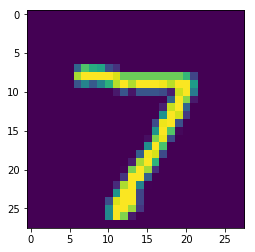

In [46]:
import matplotlib.pyplot as plt
plt.imshow(inputs[0].reshape(28,28))

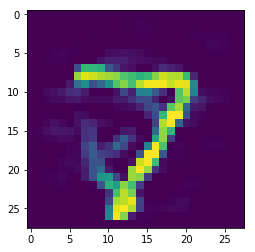

In [50]:
plt.imshow(adv[0].reshape(28,28))